In [1]:
import os, shutil
import pandas as pd
import numpy as np

In [2]:
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, Input, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications import xception, resnet50, imagenet_utils, inception_v3, inception_resnet_v2
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from sklearn.utils import shuffle
#from tensorboard_callback import TensorBoard

Using TensorFlow backend.


In [3]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.1'), 'Please use TensorFlow version 1.1 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


# 1. 数据处理

## 数据集下载
参照data_process.ipynb

## 图片目录处理

为了方便使用``keras``的 ``image.ImageDataGenerator`` 来对图片数据按batch进行流化，而不是一下子加载全部图片到内存，我们需要按``ImageDataGenerator`` 的要求来整理图片路径。

In [4]:
# 处理后给模型使用的目录
TRAIN_DIR = "data/train"
VALIDATION_DIR = "data/valid"
TEST_DIR = "data/test"

# 放全部数据
TRAIN_DIR2 = "data/train_all"

# 保存h5文件的目录
TRAIN_HUGE = True
H5_DIR = 'h5/'

# 全部数据只用于最后的测试
if TRAIN_HUGE:
    H5_DIR="h5/"
else:
    H5_DIR="small_h5/"
    
if not os.path.exists(H5_DIR):
    os.mkdir(H5_DIR)

> 注意：改变数据集大小时，要把上面两个cell都运行

## 用ImageDataGenerator对图片数据进行增强，并改变大小

In [14]:
from keras.preprocessing import image

batch_size = 16

# this is the augmentation configuration we will use for training
datagen1 = image.ImageDataGenerator(
        rescale=1./255)
# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = datagen1.flow_from_directory(
        TRAIN_DIR,
        target_size=(224, 224), 
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

datagen2 = image.ImageDataGenerator(
        rescale=1./255)

# this is a similar generator, for validation data
validation_generator = datagen2.flow_from_directory(
        VALIDATION_DIR,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

Found 3984 images belonging to 2 classes.
Found 998 images belonging to 2 classes.


# 模型

## 从简单的ConvNet开始

使用keras的Sequential，创建简单的ConvNet，测试性能。

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

simple_model = Sequential()

simple_model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
simple_model.add(Activation('relu'))
simple_model.add(MaxPooling2D(pool_size=(2, 2)))

simple_model.add(Conv2D(32, (3, 3)))
simple_model.add(Activation('relu'))
simple_model.add(MaxPooling2D(pool_size=(2, 2)))

simple_model.add(Conv2D(64, (3, 3)))
simple_model.add(Activation('relu'))
simple_model.add(MaxPooling2D(pool_size=(2, 2)))

simple_model.add(Flatten())
simple_model.add(Dense(64))
simple_model.add(Activation('relu'))
simple_model.add(Dropout(0.5))
simple_model.add(Dense(1))
simple_model.add(Activation('sigmoid'))

simple_model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [92]:
train_generator.reset()
validation_generator.reset()

In [88]:
simple_model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.n//batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.n//batch_size)

Epoch 1/10
100/100 [==============================] - 13s 127ms/step - loss: 0.6588 - acc: 0.6063 - val_loss: 0.6628 - val_acc: 0.6375

模型准确率随着迭代次数有所提高，但验证的loss下降不明显。

## 尝试深度ConvNet

### 1. 使用预训练的ResNet50网络，并加上我们的池化、FC层。

In [9]:
base_model = resnet50.ResNet50(input_tensor=Input((224, 224, 3)), weights='imagenet', include_top=False)

for layers in base_model.layers:
    layers.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
resModel = Model(base_model.input, x)

In [10]:
resModel.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [99]:
train_generator.reset()
validation_generator.reset()

In [100]:
resModel.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.n//batch_size,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=validation_generator.n//batch_size)

Epoch 1/10
100/100 [==============================] - 44s 444ms/step - loss: 0.5620 - acc: 0.7044 - val_loss: 0.7183 - val_acc: 0.5000

### 2. 配置不同的模型参数

In [5]:
from keras.preprocessing import image
from keras.applications import imagenet_utils

# 封装模型设置
def model_choice(model_name):
    return { 'Xception':
               (xception.Xception, 
                (299, 299, 3), 
                xception.preprocess_input),
            
             'InceptionResNetV2':
               (inception_resnet_v2.InceptionResNetV2, 
                (299, 299, 3), 
                inception_resnet_v2.preprocess_input),
            
             'InceptionV3':
               (inception_v3.InceptionV3, 
                (224, 224, 3), 
                imagenet_utils.preprocess_input),}.get(model_name)

### 3. 封装使用模型提取参数的逻辑

In [6]:
import h5py

def generate_features(MODEL=xception.Xception, 
                         input_shape=(299, 299, 3), 
                         batch_size=16, 
                         preprocess=xception.preprocess_input):
    
    input_tensor = Input(input_shape)
    x = input_tensor

        
    # 使用`imagenet`预训练的权重, 去掉FC层，用来提取特征map                        
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = image.ImageDataGenerator(preprocessing_function=preprocess)
                         
    # 生成训练数据集batch流
    train_generator = gen.flow_from_directory(TRAIN_DIR2,
                                            batch_size=batch_size, 
                                            shuffle=False,
                                            class_mode='binary', 
                                            target_size=input_shape[:-1])

    # 生成测试数据集batch流
    test_generator = gen.flow_from_directory(TEST_DIR,
                                            batch_size=batch_size,
                                           shuffle=False,
                                            class_mode=None, # 测试集不关心label
                                            target_size=input_shape[:-1])
    print(model.output.shape)
    
    # train 特征
    train_features = model.predict_generator(train_generator, test_generator.n/test_generator.batch_size)
    
    # test 特征
    test_features = model.predict_generator(test_generator, test_generator.n/test_generator.batch_size)
    
    # 保存训练集、验证集、测试集的features
    h5_file_name = H5_DIR + "%s.h5" % MODEL.__name__
    if os.path.exists(h5_file_name):
        os.remove(h5_file_name)
    with h5py.File(h5_file_name) as h:
        h.create_dataset("train_features", data=train_features)
        h.create_dataset("test_features", data=test_features)
        
    # 顺便保存label,label和ImageDataGenerator有关，和所选的模型无关
    h5_file_name = H5_DIR+'labels.h5'
    if os.path.exists(h5_file_name):
        return
    with h5py.File(h5_file_name) as h:
        h.create_dataset("train_labels", data=train_generator.classes)


### 4. 生成各个模型的feature并保存

* 提取Xception生成的特征，并保存

In [ ]:
MODEL, input_shape, preprocess = model_choice('Xception')
generate_features(MODEL=MODEL, input_shape=input_shape, batch_size=32, preprocess=preprocess)

Found 4982 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
(?, 2048)


> 用Xception生成5000+12500图片的特征，在p2.xlarge上耗时 14.5 分钟。

* 提取InceptionV3生成的特征，并保存

In [10]:
MODEL, input_shape, preprocess = model_choice('InceptionV3')
generate_features(MODEL=MODEL, input_shape=input_shape, batch_size=32, preprocess=preprocess)

Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
(?, 2048)


> 用InceptionV3生成5000+12500图片的特征，在p2.xlarge上耗时 15 分钟。

* 提取InceptionResNetV2生成的特征，并保存

In [ ]:
MODEL, input_shape, preprocess = model_choice('InceptionResNetV2')
generate_features(MODEL=MODEL, input_shape=input_shape, batch_size=32, preprocess=preprocess)

> 用InceptionResNetV2生成5000+12500图片的特征，在p2.xlarge上耗时 15 分钟。

### 5. 加载各个模型的feature并合并

In [17]:
H5_DIR='h5-bak/'

In [18]:
import h5py

def load_features(models=None):
    X_train = []
#     y_train, y_val = [], []
    X_test = []
    
    if not models:
        models = ["Xception.h5", "InceptionV3.h5", "InceptionResNetV2.h5"]
    for f in models:
        fn = H5_DIR+f
        with h5py.File(fn, 'r') as h:
            X_train.append(np.array(h['train_features']))
            if TRAIN_HUGE:
                X_test.append(np.array(h['test_features']))
                    
    with h5py.File(H5_DIR+'labels.h5', 'r') as h:
        y_train = np.array(h['train_labels'])
        
    X_train = np.concatenate(X_train, axis=1)
    # 最后用全部数据训练时，才需要加载测试的特征
    if TRAIN_HUGE:
        X_test = np.concatenate(X_test, axis=1)
    
    return X_train, y_train, X_test

In [21]:
X_train, y_train, X_test = load_features(models=["Xception.h5", "InceptionV3.h5", "InceptionResNetV2.h5"])

In [127]:
np.random.seed(2018)

X_train, y_train = shuffle(X_train, y_train) 

### 6. 定义混合的模型

把上面三个深度模型训练的特征，加上我们的FC层，并训练。

In [7]:
from datetime import datetime
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping

class EnsembleModel:
    def __init__(self, dropout_p = 0.5, batch_size = 32, input_shape=(2048,)):
        self.batch_size = batch_size
        input_tensor = Input(input_shape)
        x = Dropout(0.5)(input_tensor)
        x = Dense(1, activation='sigmoid')(x)
        self.model = Model(input_tensor, x)
        
        self.model.compile(optimizer='adadelta',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])        

        log_dir = 'logs/' + datetime.now().strftime('%Y%m%d-%H%M%S') + '/'
        self.tb_cb = TensorBoard(log_dir=log_dir, 
                                 batch_size=self.batch_size,)
        self.early_cb = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

    def fit(self, train_features, train_labels, valid_features, valid_labels, epochs, *args, **kwargs):
        return self.model.fit(train_features, 
                              train_labels, 
                              batch_size=self.batch_size, 
                              epochs=epochs, 
                              validation_data=(valid_features, valid_labels), 
                              callbacks=[self.tb_cb,self.early_cb], 
                              **kwargs).history
    
    def predict(self, test_features, *args, **kwargs):
        return self.model.predict(test_features, batch_size=self.batch_size, **kwargs)

In [22]:
myModel = EnsembleModel(dropout_p=0.5, batch_size=32, input_shape=(X_train.shape[1],))

训练我们的模型

In [129]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [130]:
myModel.fit(X_train, y_train, X_val, y_val, epochs=50)

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 2s 551us/step - loss: 0.3548 - acc: 0.8775 - val_loss: 0.1593 - val_acc: 0.9890

{'acc': [0.8775,
  0.98475,
  0.99075,
  0.992,
  0.993,
  0.99425,
  0.99425,
  0.9935,
  0.99475,
  0.994,
  0.9945,
  0.99475,
  0.9955,
  0.99575,
  0.995,
  0.9955,
  0.99625,
  0.997],
 'loss': [0.3548157985210419,
  0.12096631973981857,
  0.06965407156944275,
  0.04951778434216976,
  0.039286697126924994,
  0.03265152589976788,
  0.028779174115508795,
  0.028935381527990103,
  0.024450347036123275,
  0.0229846095405519,
  0.02307140118815005,
  0.02177799994125962,
  0.020309680499136448,
  0.01860569826513529,
  0.018243715343996884,
  0.015910547338426114,
  0.015367780832573771,
  0.015083001632243395],
 'val_acc': [0.989,
  0.989,
  0.99,
  0.989,
  0.99,
  0.991,
  0.991,
  0.991,
  0.992,
  0.992,
  0.992,
  0.992,
  0.992,
  0.993,
  0.993,
  0.993,
  0.993,
  0.993],
 'val_loss': [0.15932199883460998,
  0.08440787076950074,
  0.05864208945631981,
  0.045906751334667206,
  0.04065465694665909,
  0.03679863952100277,
  0.034532555863261226,
  0.03334630393236875,
  0.03225

可以看到我们只用5000个图片的训练下，验证集的loss已经达到0.0281，并提前结束训练，满足kaggle前10%的要求。

## 结果测试

In [62]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


def test_model(models):
    X_train, y_train, X_test = load_features(models=models)
    np.random.seed(2018)
    X_train, y_train = shuffle(X_train, y_train) 
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
    myModel = EnsembleModel(dropout_p=0.5, batch_size=32, input_shape=(X_train.shape[1],))
    historys = myModel.fit(X_train, y_train, X_val, y_val, epochs=50)

    name = ""
    if len(models)>=2:
        name = 'Ensemble'
    else:
        name = models[0][:-3]
    # summarize history for accuracy
    plt.plot(historys['acc'])
    plt.plot(historys['val_acc'])
    plt.title('{} accuracy'.format(name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(historys['loss'])
    plt.plot(historys['val_loss'])
    plt.title('{} loss'.format(name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    return myModel

### 1. 单独使用 Xception的特征

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 1s 161us/step - loss: 0.3334 - acc: 0.9387 - val_loss: 0.1782 - val_acc: 0.9920
Epoch 2/50
4000/4000 [===========================

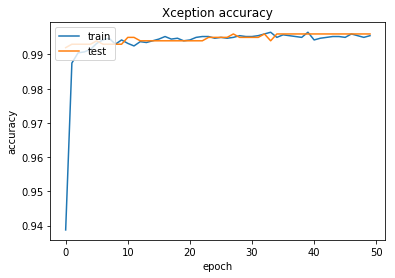

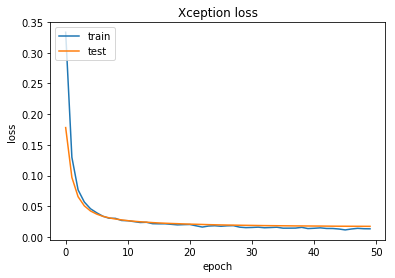

In [54]:
myModel, historys = test_model(['Xception.h5'])

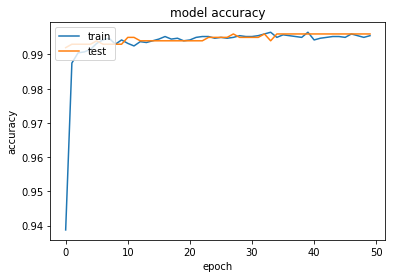

In [39]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(historys['acc'])
plt.plot(historys['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

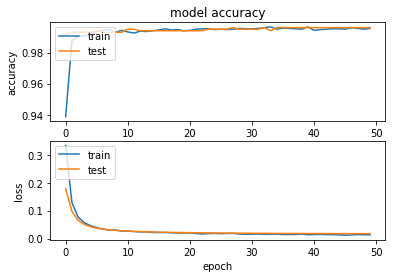

In [45]:
plt.subplot(2,1,1)
plt.plot(historys['acc'])
plt.plot(historys['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
# plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(2,1,2)

plt.plot(historys['loss'])
plt.plot(historys['val_loss'])
# plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

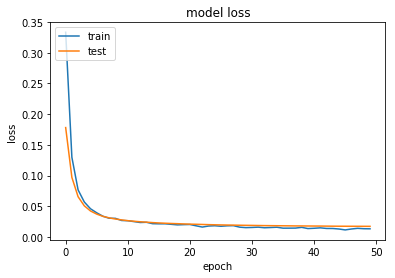

In [46]:
# summarize history for loss
plt.plot(historys['loss'])
plt.plot(historys['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 2. 单独使用InceptionV3的特征

In [32]:
test_model(['InceptionV3.h5'])

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 1s 257us/step - loss: 4.5656 - acc: 0.5350 - val_loss: 2.6659 - val_acc: 0.5890

### 3. 单独使用InceptionResNetV2的特征

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 1s 165us/step - loss: 0.2917 - acc: 0.9150 - val_loss: 0.1389 - val_acc: 0.9870

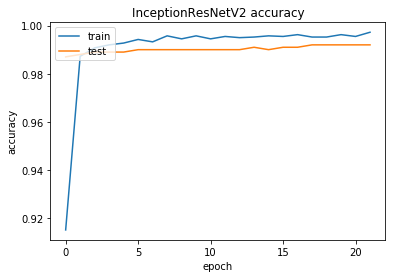

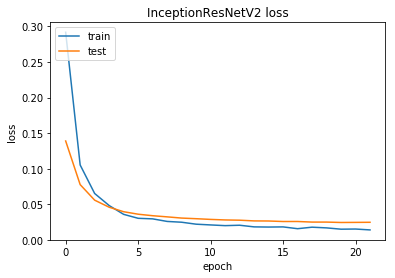

(<__main__.EnsembleModel at 0x7f642349dc50>,
 {'acc': [0.915,
   0.98725,
   0.99075,
   0.992,
   0.99275,
   0.99425,
   0.99325,
   0.99575,
   0.9945,
   0.99575,
   0.9945,
   0.9955,
   0.995,
   0.99525,
   0.99575,
   0.9955,
   0.99625,
   0.99525,
   0.99525,
   0.99625,
   0.9955,
   0.99725],
  'loss': [0.29172253954410554,
   0.10521479445695878,
   0.06515526328980922,
   0.04821500895917415,
   0.03583519833534956,
   0.030286663047969342,
   0.029505097519606352,
   0.025897284895181658,
   0.024774481873959302,
   0.02201975757814944,
   0.020969358304515483,
   0.01997802161425352,
   0.020538271652534603,
   0.018243172444403172,
   0.017990690471604467,
   0.01820541796181351,
   0.015679553198628127,
   0.017806058447808026,
   0.016821751614566893,
   0.014991677207406611,
   0.015214673371054232,
   0.013968233536928892],
  'val_acc': [0.987,
   0.988,
   0.989,
   0.989,
   0.989,
   0.99,
   0.99,
   0.99,
   0.99,
   0.99,
   0.99,
   0.99,
   0.99,
   0.991,


In [ ]:
test_model(['InceptionResNetV2.h5'])

### 4. 整合使用多模型的特征

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 1s 174us/step - loss: 0.2271 - acc: 0.9525 - val_loss: 0.0904 - val_acc: 0.9920

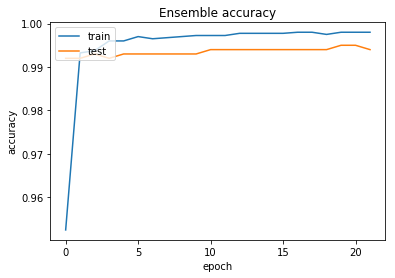

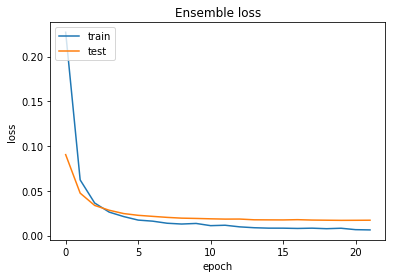

In [63]:
myModel = test_model(["Xception.h5", "InceptionResNetV2.h5"])

## 模型结果图形化

In [148]:
# 顺序与特征生成时一致
gen = image.ImageDataGenerator()
train_generator = gen.flow_from_directory(TRAIN_DIR2,
                                        batch_size=32, 
                                        shuffle=False,
                                        class_mode='binary', 
                                        target_size=(150,150))

Found 5000 images belonging to 2 classes.


In [149]:
X_train, y_train, X_test = load_features(models=["Xception.h5", "InceptionResNetV2.h5"])
np.random.seed(2018)
indexs = np.array(list(range(len(X_train))))
X_train, X_val, y_train, y_val, index_train, index_val = train_test_split(X_train, y_train, indexs, test_size=0.2, shuffle=True)
myModel = EnsembleModel(dropout_p=0.5, batch_size=32, input_shape=(X_train.shape[1],))
historys = myModel.fit(X_train, y_train, X_val, y_val, epochs=50)

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
4000/4000 [==============================] - 1s 183us/step - loss: 0.2162 - acc: 0.9607 - val_loss: 0.0828 - val_acc: 0.9920

In [150]:
y_val_pred = myModel.predict(X_val, verbose=1)

1000/1000 [==============================] - 0s 164us/step


In [180]:
from keras.preprocessing.image import load_img, img_to_array

def my_display(imgs, n=5, fdir='input/train/'):    
    fig = plt.figure(figsize=(16, 8))
    for j, fn in enumerate(imgs):
        fn2 = fdir+fn
        img = load_img(fn2, target_size=(150, 150))
        fig.add_subplot(1, n, j + 1)
        f = plt.imshow(img)
        plt.title('{}'.format(fn))
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

在验证集上查看效果

In [151]:
y_val_pred2 = np.round(y_val_pred[:,0]).astype(np.int32)

In [152]:
correct = np.where(y_val_pred2==y_val)

In [153]:
len(correct[0])

995

In [154]:
incorrect = np.where(y_val_pred2!=y_val)

In [182]:
imgs = [train_generator.filenames[f] for f in incorrect[0]]

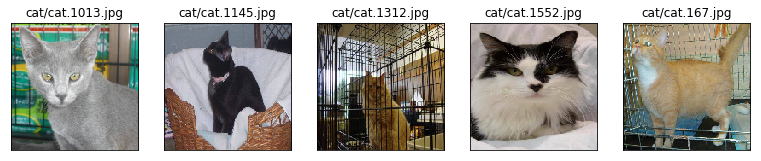

In [184]:
my_display(imgs, n=6, fdir=TRAIN_DIR2+'/')

### 在测试集上展示效果

In [195]:
# 顺序与特征生成时一致
gen = image.ImageDataGenerator()
test_generator = gen.flow_from_directory(TEST_DIR,
                                        batch_size=32, 
                                        shuffle=False,
                                        class_mode='binary', 
                                        target_size=(150,150))

Found 12500 images belonging to 1 classes.


In [222]:
y_pred = myModel.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

12500/12500 [==============================] - 0s 38us/step


In [225]:
len(np.where(y_pred>0.95)[0]), len(np.where(y_pred<0.05)[0]), len(np.where((y_pred>0.5) & (y_pred<0.55))[0]), len(np.where((y_pred>0.45) & (y_pred<0.5))[0])

(6152, 6130, 3, 6)

In [241]:
test_dog_rs = np.where(y_pred>0.95)[0][:5]
imgs = [test_generator.filenames[f] for f in test_dog_rs]

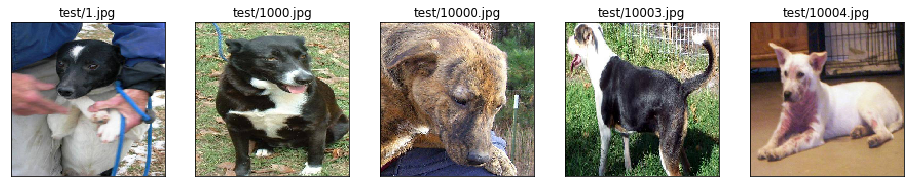

In [242]:
my_display(imgs, n=5, fdir=TEST_DIR+'/')

In [221]:
len(np.where(y_pred<0.05)), 

(2,)

In [239]:
test_cat_rs = np.where(y_pred<0.05)[0][:5]
imgs = [test_generator.filenames[f] for f in test_cat_rs]

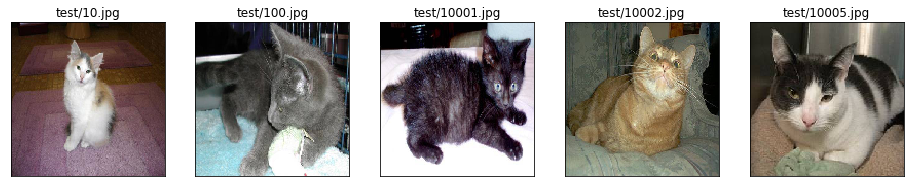

In [240]:
my_display(imgs, n=5, fdir=TEST_DIR+'/')

In [237]:
test_cat_low_rs = np.where((y_pred>0.45) & (y_pred<0.5))[0][:5]
imgs = [test_generator.filenames[f] for f in test_cat_low_rs]

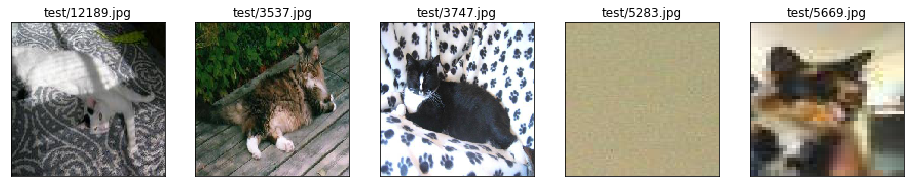

In [238]:
my_display(imgs, n=5, fdir=TEST_DIR+'/')

In [247]:
test_dog_low_rs = np.where((y_pred>0.5) & (y_pred<0.6))[0][:3]
imgs = [test_generator.filenames[f] for f in test_dog_low_rs]

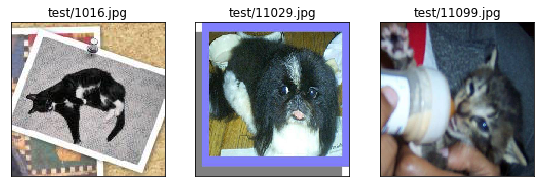

In [248]:
my_display(imgs, n=5, fdir=TEST_DIR+'/')

## 提交kaggle

最后一步生成summition.csv。

In [23]:
y_pred = myModel.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

12500/12500 [==============================] - 3s 206us/step


In [24]:
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(TEST_DIR, (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred-inceptionrestv2.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


,id,label
0,1,0.995000
1,2,0.993609
2,3,0.995000
3,4,0.976898
4,5,0.995000
5,6,0.886106
6,7,0.879489
7,8,0.995000
8,9,0.995000
9,10,0.603476


提交后，最后看到的得分是0.04093，大概前20名左右。如果加大数据训练，效果应该更好一点。